# Sistema de Recomendação Autoexplicativo para Gestão de Alimentos
## Inteligência Artificial Centrada no Humano - MECD (2023/2024)

- Carlos Matos - 2020245868
- Mariana Magueijo - 2020246886

In [386]:
import pandas as pd
import datetime
import pickle as pkl
import os
import matplotlib.pyplot as plt
import numpy as np

In [387]:
ingredients_recipes = {}
recipe_ingredients = {}
author_recipes = {}
time_recipes = {}
recipe_review = {}
user_review = {}
array_ingredients_expired = []
user_author = {}

In [388]:
def read_file(path):
    file = pd.read_csv(path)
    df = pd.DataFrame(file)
    return df

In [389]:
def create_array_time(df_recipes):
    array_time = []

    for i in range(len(df_recipes)):
        time = df_recipes["Total Time"][i]
        if time == "X":
            array_time.append(0)
        elif len(time) == 3:      #1 d ou 1 h ou 1 m                                      
            divide = time.split(" ")
            if divide[1] == "h":
                array_time.append(int(divide[0]) * 60)
            elif divide[1] == "m":
                array_time.append(int(divide[0]))
            elif divide[1] == "d":
                array_time.append(int(divide[0]) * 24 * 60)
        elif len(time) == 4:    #30 m ou 10 h
            if 'm' in time:
                array_time.append(int(time.split(" m")[0]))
            elif 'h' in time:
                array_time.append(int(time.split(" h")[0]) * 60)
            
        elif len(time) == 8 or len(time) == 7:
            t = 0
            if 'd' in time:     #1 d 1 h ou 1 d 30 m
                divide = time.split(" d ")
                t += int(divide[0]) * 60 * 24
                if 'm' in divide[1]:
                    t += int(divide[1].split(" m")[0])
                elif 'h' in divide[1]:
                    t += int(divide[1].split(" h")[0]) * 60
            elif 'h' in time:       #12 h 2 m ou 1 h 20 m ou 1 h 2 m
                divide = time.split(" h ")
                t += int(divide[0]) * 60 + int(divide[1].split(" m")[0])
            
            array_time.append(t)
        elif len(time) == 9:    #12 h 20 m ou 12 d 12 h ou 12 d 20 m
            t = 0
            if "d" in time:
                divide = time.split(" d ")
                t += int(divide[0]) * 24 * 60
                if "m" in divide[1]:
                    t += int(divide[1].split(" m")[0])
                elif "h" in divide[1]:
                    t += int(divide[1].split(" h")[0])
            elif "h" in time:
                divide = time.split(" h ")
                t += int(divide[0]) * 60 + int(divide[1].split(" m")[0])
            array_time.append(t)
        elif len(time) == 11 or len(time) == 12 or len(time) == 13 or len(time) == 14:     #1 d 1 h 5 m ou 1 d 1 h 50 m ou 1 d 10 h 50 m ou 10 d 10 h 50 m
            divide = time.split(" d ")
            t = int(divide[0]) * 24 * 60
            div = divide[1].split(" h ")
            t += int(div[0]) * 60 + int(div[1].split(" m")[0])
            array_time.append(t)
            
    return array_time

In [390]:
def clean_x(df_recipes):
    for i in range(len(df_recipes)):
        if df_recipes["Total Time"][i] == "X":
            time = df_recipes["Total Time"][i]
            index_line = df_recipes.index[df_recipes["Total Time"] == time].tolist()[0]
            df_recipes = df_recipes.drop(index_line)

    return df_recipes
    

In [391]:
def create_array_review(df_recipes):
    array_review = []
    for i in range(len(df_recipes)):
        review = df_recipes["Review Count"][i]
        if "k" in review:
            array_review.append(int(review.split("k")[0]) * 1000)
        else:
            array_review.append(int(review))
    return array_review

In [392]:
def create_ingredients_recipes(df_recipes):
    for i in range(len(df_recipes)):
        ingredients = df_recipes["Ingredients"][i]
        list_ingred = ingredients.split(',')
        for ing in list_ingred:
            if ing not in ingredients_recipes:
                ingredients_recipes[ing] = [df_recipes["Recipe Name"][i]]
            else:
                ingredients_recipes[ing].append(df_recipes["Recipe Name"][i])

In [393]:
def create_recipe_ingredient(df_recipes):
    for i in range(len(df_recipes)):
        ingredients = df_recipes["Ingredients"][i].split(",")
        recipe_ingredients[df_recipes["Recipe Name"][i]] = ingredients

In [394]:
def create_author_recipes(df_recipes):
    for i in range(len(df_recipes)):
        author = df_recipes["Author"][i]
        if author not in author_recipes:
            author_recipes[author] = [df_recipes["Recipe Name"][i]]
        else:
            author_recipes[author].append(df_recipes["Recipe Name"][i])


In [395]:
def create_time_recipes(df_recipes):
    global time_recipes
    for i in range(len(df_recipes)):
        time = df_recipes["Total Time (min)"][i]
        if time not in time_recipes:
            time_recipes[time] = [df_recipes["Recipe Name"][i]]
        else:
            time_recipes[time].append(df_recipes["Recipe Name"][i])
            
    time_recipes = dict(sorted(time_recipes.items()))

In [396]:
def create_recipe_review(df_recipes):
    for i in range(len(df_recipes)):
        recipe_review[df_recipes["Recipe Name"][i]] = df_recipes["Review Count"][i]

In [397]:
def create_user_review(df_review):
    global user_review
    if os.path.exists("dataset/user_reviews.pkl"):
        with open("dataset/user_reviews.pkl", 'rb') as arq:
            user_review =  pkl.load(arq)
    else:
        for i in range(len(df_review)):
            user = df_review["Name"][i]
            user_review[user] = {}
            for j in range(6):
                rank = df_review[str(j)][i]
                if rank == " ":
                    user_review[user][str(j)] = []
                elif ',' in rank:
                    list_recipes = rank.split(",")
                    user_review[user][str(j)] = list_recipes
                else:
                    user_review[user][str(j)] = [rank]
        with open("dataset/user_reviews.pkl", 'wb') as arq:
            pkl.dump(user_review, arq)

In [398]:
def create_user_author(name, df_recipes):
    global user_author
    d_author_ranks = {}
    d_author_recipes = {}
    for rank in user_review[name]:
        for recipe in user_review[name][rank]:

            line_index = df_recipes.index[df_recipes["Recipe Name"] == recipe].tolist()[0]
            author = df_recipes["Author"][line_index]
            if author in d_author_ranks:
                d_author_ranks[author].append(int(rank))
                d_author_recipes[author].append(recipe)
            else:
                d_author_ranks[author] = [int(rank)]
                d_author_recipes[author] = [recipe]
    
    for author in d_author_ranks:
        m = int(np.mean(d_author_ranks[author]))
        if m > 2:
            user_author[author] = [m, d_author_recipes[author]]
    user_author = dict(sorted(user_author.items(), key=lambda item: item[1][0], reverse=True))


In [399]:
def plot_distributions(dic, title, xlabel, ylabel, number, orientation, x, y, fontesize):
    x_values = [i for i in dic if len(dic[i]) > number]
    y_values = [len(dic[i]) for i in dic if len(dic[i]) > number]
    
    plt.figure(figsize=(x, y))
    plt.bar(x_values, y_values, color='blue')                
    plt.title(title)
    plt.xticks(rotation=orientation, fontsize=fontesize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [400]:
def plot_top10_distributions(dic, top, title, xlabel, ylabel, orientation, x, y, is_list):
    if is_list:
        new_dic = dict(sorted(dic.items(), key=lambda x: len(x[1]), reverse=True))
        x_values = []
        y_values = []
        count = 0
        for i in new_dic:
            x_values.append(i)
            y_values.append(len(new_dic[i]))
            if count == top:
                break
            count += 1
    else:
        new_dic = dict(sorted(dic.items(), key=lambda x: x[1], reverse=True))
        x_values = []
        y_values = []
        count = 0
        for i in new_dic:
            x_values.append(i)
            y_values.append(new_dic[i])
            if count == top:
                break
            count += 1
    
    plt.figure(figsize=(x, y))
    plt.bar(x_values, y_values, color='blue')                
    plt.title(title)
    plt.xticks(rotation=orientation)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


In [401]:
def register():
    print("-"*40 + " Welcome to Pendia " + "-"*40)
    print("1- Log In;\n2- Sing In;\n0- Leave;")
    option = input("1- Log In\n2- Sing In\n0- Leave\n")
    name = ""
    password = ""
    state = False
    while option != "0":
        if os.path.exists("dataset/users.pkl"):
            with open("dataset/users.pkl", 'rb') as arq:
                d_users =  pkl.load(arq)
        else:
            d_users = {}
        if option == "1" and d_users == {}:
            print("Without users")
        elif option == "1":
            while(1):
                name = input("Name: ")
                print("Name: " + name)
                if name in d_users:
                    break
                else:
                    print("Incorret Name")
            while(1):
                password = input("Password: ")
                print("Password: " + password)
                if d_users[name] == password:
                    break
                else:
                    print("Incorret Password")
            print("-"*40 + " Hi " + name + " " + "-"*40)
            state = True
        elif option == "2":
            while(1):
                name = input("Name: ")
                print("Name: " + name)
                if name not in d_users:
                    password = input("Password: ")
                    print("Password: " + password)
                    d_users[name] = password
                    break
                else:
                    print("User Already exists")
            with open("dataset/users.pkl", 'wb') as arq:
                pkl.dump(d_users, arq)
            print("-"*40 + " Hi " + name + " " + "-"*40)
            state = True
        else:
            print("Invalid Option")
            
        if state:
            option = "0"
        else:
            print("1- Log In;\n2- Sing In;\n0- Leave;")
            option = input("1- Log In;\n2- Sing In;\n0- Leave;\n")

    if not state: 
        print("Bye, Have a Great Time!")
        return None
    
    return [name, password]

In [402]:
def validation_date(df_user, string_data):
    day_to_validation = []
    actual_date_obj = datetime.datetime.strptime(string_data, "%Y-%m-%d")
    for i in range(len(df_user)):
        date_obj = datetime.datetime.strptime(df_user["Expiration Date"][i], "%Y-%m-%d")
        day_to_validation.append(actual_date_obj - date_obj)
    return day_to_validation

In [403]:
def ingredients_expirated(day_to_validation, df_user):
    print("Do you want to know what ingredients are expired and what are about to expire? (1- Yes/2- No)")
    option = input("Do you want to know what ingredients are expired and what are about to expire? (1- Yes/2- No)")
    if option == "1":
        for i in range(len(day_to_validation)):
            if day_to_validation[i].days > 0:
                print("Ingredient " + df_user["Ingredients"][i] + " is expired")
            elif -15 <= day_to_validation[i].days <= 0:
                print("Ingredient " + df_user["Ingredients"][i] + " expire in " + str(abs(day_to_validation[i].days)) + " days.") 
    for i in range(len(day_to_validation)):
        if -15 <= day_to_validation[i].days <= 0:
            array_ingredients_expired.append(df_user["Ingredients"][i])            

In [404]:
def register_product(df_user):
    print("-"*20 + " Register Product " + "-"*20)
    
    name = input("Product Name: ")
    print("Product Name: " + name)
    quantity = input("Product Quantity: ")
    print("Product Quantity: " + quantity)
    day = input("Day of Validation: ")
    print("Day of Validation: " + day)
    month = input("Month of Validation: ")
    print("Month of Validation: " + month)
    year = input("Year of Validation: ")
    print("Year of Validation: " + year)
    
    date = year + "-" + month + "-" + day
    id = len(df_user)
    new_line = {"Ingredients": name, "Quantity": int(quantity), "Expiration Date": date, "Id": id}
    new_line = pd.DataFrame([new_line], columns=df_user.columns)
    df_user = pd.concat([df_user, new_line], ignore_index=True)
    
    return df_user
    

In [405]:
def eliminate_product(df_user):
    print("-"*20 + " Eliminate Product " + "-"*20)
    id = ""
    while(1):
        id = input("Product Id: ")
        print("Product Id: " + id)
        if int(id) not in df_user["Id"]:
            print("Product Id " + id + " doesn't exists\n")
        else:
            break
    index_line = df_user.index[df_user["Id"] == int(id)].tolist()[0]
    df_user = df_user.drop(index_line)
    print("Product " + df_user["Ingredients"][index_line] + " eliminated")
     
    return df_user

In [406]:
def modelo_previsão(user, d_recipe_prod):
    dic = {}
    user_login = {}
    user_rankings = []

    for recipe in d_recipe_prod.keys():
        for rank in user_review[user].keys():
            for i in user_review[user][rank]:
                user_rankings.append(i)
                if recipe in user_review[user][rank]:
                    user_login[recipe] = int(rank)
    
    for name_user in user_review.keys():
        interseption = 0.0
        union = 0.0
        value = 0.0
        array_user = []
        if name_user != user:
            for rank in user_review[name_user].keys():
                for i in user_review[name_user][rank]:
                    array_user.append(i)
            interseption = len([set(array_user) & set(user_rankings)])
            union = len(list(set(array_user) | set(user_rankings)))
            value = interseption/union
            if (value > 0.7): 
                dic[name_user] = int(value)
    dicionario_ordenado = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

    x = 0
    for recipe in d_recipe_prod.keys():
        total = 0.00
        total_2 = 0.00
        for name_user in user_review.keys():
            if name_user != user:
                for rank in user_review[name_user].keys():
                    for i in user_review[name_user][rank]:
                        if recipe == i and x < 6 and name_user in dicionario_ordenado.keys(): 
                            total += dicionario_ordenado[name_user] * int(rank)
                            total_2 += dicionario_ordenado[name_user]
                            x += 1
        
        if total_2 != 0.0 and recipe not in user_login.keys():
            total_final = total/total_2
            user_login[recipe] = int(total_final)

    d_final = dict(sorted(user_login.items(), key=lambda item: item[1], reverse=True)) 
    return d_final

In [407]:
def ordenate_by_ranking(d_final, d_recipe_prod):
    d_recipes_ordenated = {}
    for recipes in d_final.keys():
        values = []
        values.append(d_final[recipes])
        array_expired = []
        for i in recipe_ingredients[recipes]:
            if i in array_ingredients_expired:
                array_expired.append(i)
        values.append(array_expired)
        values.append(d_recipe_prod[recipes])
        d_recipes_ordenated[recipes] = values
    
    d_final_ordenated = dict(sorted(d_recipes_ordenated.items(), key=lambda item: len(item[1][1]), reverse=True))
    return d_final_ordenated

In [408]:
def time_to_cook():
    day = input("Day: ")
    hours = input("Hours: ")
    minutes = input("Minutes: ")
    total_time = int(day) * 24 * 60 + int(hours) * 60 + int(minutes)
    t = ""
    if int(day) > 0:
        t += day + "d "
    if int(hours) > 0:
        t += hours + "h "
    if int(minutes) > 0:
        t += minutes + "m"
    print("Time to spent doing the recipe: " + t)       
    array_recipes_time = []
    for time in time_recipes:
        if total_time >= time:
            for recipe in time_recipes[time]:
                array_recipes_time.append(recipe)
    return array_recipes_time

In [409]:
def missing_ingredients(array_recipes_time, df_recipes, df_user):
    d_recipe_prod = {}
    ingredients = [i for i in df_user["Ingredients"]]
    
    for recipe in array_recipes_time:
        line = df_recipes.index[df_recipes["Recipe Name"] == recipe].tolist()[0]
        r_ingredients = df_recipes["Ingredients"][line].split(",")
        aux = []
        for ing in r_ingredients:
            if ing not in ingredients and ing not in aux:
                aux.append(ing)
        if len(aux) <= 2:
            d_recipe_prod[recipe] = aux
    return d_recipe_prod

In [410]:
def explicability(d_ordenated, as_author):
    print("-"*20 + "\nHere you have our recommended recipes!")
    done_1 = True
    done_3 = True
    done_4 = True
    for recipe in d_ordenated:
        if len(d_ordenated[recipe][1]) > 0:
            if done_1:
                print("-"*20 + "\nRecipes with ingredients almost expired:")
                done_1 = False
            string = recipe +  ": "
            done_2 = True
            for i in range(d_ordenated[recipe][0]):
                string += "*"
                done_2 = False
            if done_2:
                string += "0"
            print(string)
            string = "Ingredients about to expire: "
            for ing in d_ordenated[recipe][1]:
                string += ing + "; "
            print("\t-" + string)
            if len(d_ordenated[recipe][2]) > 0:
                string = "Ingredients missing: "
                for ing in d_ordenated[recipe][2]:
                    string += ing + "; "
                print("\t-" + string)
            else:
                print("\t-No ingredients missing")
            if as_author:
                print("\t-Author: " + d_ordenated[recipe][3])
            done_3 = False

    for recipe in d_ordenated:
        if done_4:
            if done_3:
                print("-"*20 + "\nYou don't have any recipes that contain ingredients that are about to expire.\nList of recipes recommended(by rating):")
            else:
                print("-"*20 + "\nList of recipes recommended(by rating):")
            done_4 = False
        if len(d_ordenated[recipe][1]) == 0:
            string = recipe +  ": "
            done_2 = True
            for i in range(d_ordenated[recipe][0]):
                string += "*"
                done_2 = False
            if done_2:
                string += "0"
            print(string)
            
            if len(d_ordenated[recipe][2]) > 0:
                string = "Ingredients missing: "
                for ing in d_ordenated[recipe][2]:
                    string += ing + "; "
                print("\t-" + string)
            else:
                print("\t-No ingredients missing")
            if as_author:
                print("\t-Author: " + d_ordenated[recipe][3])


In [411]:
def explicability_no_rating(d_ordenated):
    print("-"*20 + "\nHere you have some recipes wihtou rating!")
    done_1 = True
    done_3 = True
    done_4 = True
    count = 0
    for recipe in d_ordenated:
        if count == 8:
            break
        if len(d_ordenated[recipe][0]) > 0:
            if done_1:
                print("-"*20 + "\nRecipes with ingredients almost expired:")
                done_1 = False
            print(recipe)
            string = "Ingredients about to expire: "
            for ing in d_ordenated[recipe][0]:
                string += ing + "; "
            print("\t-" + string)
            if len(d_ordenated[recipe][1]) > 0:
                string = "Ingredients missing: "
                for ing in d_ordenated[recipe][1]:
                    string += ing + "; "
                print("\t-" + string)
            else:
                print("\t-No ingredients missing")
            done_3 = False
            count += 1

    for recipe in d_ordenated:
        if count == 8:
            break
        if done_4:
            if done_3:
                print("-"*20 + "\nYou don't have any recipes that contain ingredients that are about to expire.\nList of recipes withou rating:")
            else:
                print("-"*20 + "\nList of recipes withou rating:")
            done_4 = False
        if len(d_ordenated[recipe][0]) == 0:
            print(recipe)
            
            if len(d_ordenated[recipe][1]) > 0:
                string = "Ingredients missing: "
                for ing in d_ordenated[recipe][1]:
                    string += ing + "; "
                print("\t-" + string)
            else:
                print("\t-No ingredients missing")
            count += 1


In [412]:
def recipe_in_array_time(array_recipes_time):
    d_new = {}
    for c, k in user_author.items():
        for recipe in k[1]:
            if recipe in array_recipes_time:
                d_new[c] = k
    return d_new


In [413]:
def user_author_missing_ing(new_user_author, df_recipes, df_user, name):
    d_final = {}
    ingredients = [i for i in df_user["Ingredients"]]
    for author in new_user_author:
        for recipe in new_user_author[author][1]:
            line = df_recipes.index[df_recipes["Recipe Name"] == recipe].tolist()[0]
            r_ingredients = df_recipes["Ingredients"][line].split(",")
            missing_ingredients = []
            for ing in r_ingredients:
                if ing not in ingredients:
                    missing_ingredients.append(ing)
                    
            array_expired = []
            for i in recipe_ingredients[recipe]:
                if i in array_ingredients_expired and i not in array_expired:
                    array_expired.append(i)

            rank = 0
            for ranks in user_review[name]:
                if recipe in user_review[name][ranks]:
                    rank = int(ranks)
                    break
            if len(missing_ingredients) <= 2:
                d_final[recipe] = [rank, array_expired, missing_ingredients, author]
        
    d_final = dict(sorted(d_final.items(), key=lambda item: len(item[1][1]), reverse=True))
    
    return d_final         

In [414]:
def without_ranking_info(recipes_wihout_ranking, df_recipes, df_user):
    d_final = {}
    ingredients = [i for i in df_user["Ingredients"]]
    for recipe in recipes_wihout_ranking:
        line = df_recipes.index[df_recipes["Recipe Name"] == recipe].tolist()[0]
        r_ingredients = df_recipes["Ingredients"][line].split(",")
        missing_ingredients = []
        for ing in r_ingredients:
            if ing not in ingredients:
                missing_ingredients.append(ing)
                
        array_expired = []
        for i in recipe_ingredients[recipe]:
            if i in array_ingredients_expired and i not in array_expired:
                array_expired.append(i)
        if len(missing_ingredients) <= 2:
            d_final[recipe] = [array_expired, missing_ingredients]
        
    d_final = dict(sorted(d_final.items(), key=lambda item: len(item[1][0]), reverse=True))

    return d_final

In [415]:
def recipe_without_rating(array_recipes_time, name):
    recipes_wihout_ranking = []
    for recipe in array_recipes_time:
        for rank in user_review[name]:
            if recipe not in user_review[name][rank]:
                recipes_wihout_ranking.append(recipe)
                break
    return recipes_wihout_ranking

In [416]:
def make_recipe(df_recipes, df_user, name):
    print("-"*20 + " Make Recipe " + "-"*20)
    print("What recipes do you want? (1-By recipes ranking/2-By author ranking)")

    option = input("What recipes do you want? (1-By recipes ranking/2-By author ranking)")
    array_recipes_time = time_to_cook()
    if option == "1":
        d_recipe_prod = missing_ingredients(array_recipes_time, df_recipes, df_user)
        d_recipes_predicted = modelo_previsão(name, d_recipe_prod)
        d_ordenated = ordenate_by_ranking(d_recipes_predicted, d_recipe_prod)
        recipes_wihout_ranking = recipe_without_rating(array_recipes_time, name)
        d_without_info = without_ranking_info(recipes_wihout_ranking, df_recipes, df_user)
        explicability(d_ordenated, False)
        explicability_no_rating(d_without_info)
    elif option == "2":
        new_user_author = recipe_in_array_time(array_recipes_time)
        d_recipe_info = user_author_missing_ing(new_user_author, df_recipes, df_user, name)
        explicability(d_recipe_info, True)

In [417]:
def rank_recipe(name, df_recipes):
    print("-"*20 + " Rank a Recipe " + "-"*20)
    print("Do you wanna know what recipes are available?(1- Yes/2- No)")
    option = input("Do you wanna know what recipes are available?(1- Yes/2- No)")
    if option == "1":
        columns = ["Recipe Name", "RecipeID"]
        df_aux = df_recipes[columns]
        display(df_aux)
    
    recipe_id = input("Choose a RecipeID: ")
    print("Choose a RecipeID: " + recipe_id)
    recipe_name = df_recipes.loc[df_recipes["RecipeID"] == int(recipe_id), "Recipe Name"].values[0]
    
    already_ranked = False
    rank = -1
    for ranks in user_review[name]:
        if recipe_name in user_review[name][ranks]:
            already_ranked = True
            rank = ranks
            break
    if already_ranked:
        print("You already ranked the recipe " + recipe_name + " with " + str(rank) + ". you want to change it?(1- Yes/2- No)")
        change = input("You already ranked the recipe " + recipe_name + " with " + str(rank) + ". you want to change it?(1- Yes/2- No)")
        if change == "1":
            user_review[name][rank].remove(recipe_name)
            while(1):
                new_rank = input("Rank (0-5): ")
                print("Rank(0-5): " + new_rank)
                if new_rank == "0" or new_rank == "1" or new_rank == "2" or new_rank == "3" or new_rank == "4" or new_rank == "5":
                    user_review[name][new_rank].append(recipe_name)
                    break
                elif new_rank == rank:
                    print("Same Rank")
                else:
                    print("Invalid Option")
    else:
        while(1):
            new_rank = input("Rank (0-5): ")
            print("Rank (0-5): " + new_rank)
            if new_rank == "0" or new_rank == "1" or new_rank == "2" or new_rank == "3" or new_rank == "4" or new_rank == "5":
                user_review[name][new_rank].append(recipe_name)
                break
            else:
                print("Invalid Option")

    with open("dataset/user_reviews.pkl", 'wb') as arq:
        pkl.dump(user_review, arq)

In [418]:
def choose_options(df_user, df_recipes, name, path):
    while(1):
        print("1- Register Product\n2- Eliminate Product\n3- Make Recipe\n4- Rank a Recipe\n5- Leave\n")
        option = input("1- Register Product\n2- Eliminate Product\n3- Make Recipe\n4- Rank a Recipe\n5- Leave")
        if option == "1":
            df_user = register_product(df_user) 
        elif option == "2":
            df_user = eliminate_product(df_user)
        elif option == "3":
            make_recipe(df_recipes, df_user, name)
        elif option == "4":
            rank_recipe(name, df_recipes)
        elif option == "5":
            df_user.to_csv(path, index=False)
            print("Bye, Have a Great Time!")
            break
        else:
            print("Invalid Option")

In [419]:
def user_interface(df_recipes):
    array_login = register()
    if array_login is None:
        return
    create_user_author(array_login[0], df_recipes)
    path = "dataset/" + array_login[0] + ".csv"
    actual_data = datetime.datetime.today()
    string_data = str(actual_data.year) + "-" + str(actual_data.month) + "-" + str(actual_data.day)
    print("Current date: " + string_data)
    
    if os.path.exists(path):
        df_user = read_file(path)
        day_to_validation = validation_date(df_user, string_data)
        ingredients_expirated(day_to_validation, df_user)
        choose_options(df_user, df_recipes, array_login[0], path)
    else:
        print("1- Register Product\n2- Eliminate Product\n3- Make Recipe\n4- Rank a Recipe\n5- Leave\n")
        dic = {"Ingredients": [], "Quantity": [], "Expiration Date": [], "Id": []}
        df_user = pd.DataFrame(dic)
        choose_options(df_user, df_recipes, array_login[0], path)


In [420]:
def main():
    path = "dataset/"
    path2 = "dataset/user_reviews_complete.csv"
    if os.path.exists(path + "Final_recipes.csv"):
        path += "Final_recipes.csv"
        df_recipes = read_file(path)
    else:
        path += "clean_recipes.csv"
        df_recipes = read_file(path)
        array_time = create_array_time(df_recipes)
        df_recipes["Total Time (min)"] = array_time
        array_review = create_array_review(df_recipes)
        df_recipes["Review Count"] = array_review
        df_recipes.to_csv("dataset/Final_recipes_with_x.csv", index=False)
        df_recipes = clean_x(df_recipes)
        df_recipes.to_csv("dataset/Final_recipes.csv", index=False)
    df_review = read_file(path2)

    create_ingredients_recipes(df_recipes)
    create_recipe_ingredient(df_recipes)
    create_author_recipes(df_recipes)
    create_time_recipes(df_recipes)
    create_recipe_review(df_recipes)
    create_user_review(df_review)
    
    top = 10
    plot_distributions(ingredients_recipes, "Ingredients Distribution", "Ingredients", "Number of Recipes", 100, "vertical", 15, 5, 5) 
    plot_top10_distributions(ingredients_recipes, top, "Top 10 Ingredients Distribution", "Top 10 Ingredients", "Number of Recipes", "horizontal", 10, 5, True)
    
    plot_distributions(author_recipes, "Author Distribution", "Authors", "Number of Recipes", 5, "vertical", 15, 5, 4) 
    plot_top10_distributions(author_recipes, top, "Top 10 Authors Distribution", "Top 10 Authors", "Number of Recipes", "vertical", 10, 5, True)
    
    plot_distributions(time_recipes, "Time Distribution", "Time (min)", "Number of Recipes", 5, "horizontal", 15, 5, 10) 
    plot_top10_distributions(time_recipes, top, "Top 10 Times Distribution", "Top 10 Times (min)", "Number of Recipes", "horizontal", 10, 5, True)

    plot_top10_distributions(recipe_review, top, "Top 10 Recipes Distribution", "Top 10 Recipes", "Review", "vertical", 10, 5, False)
    
    user_interface(df_recipes)

    
    

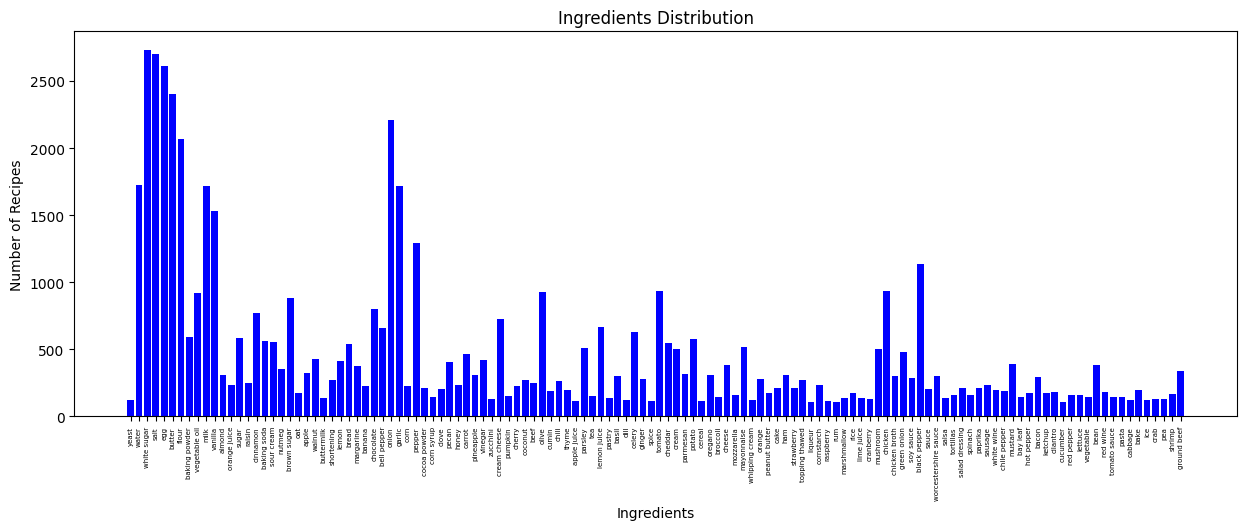

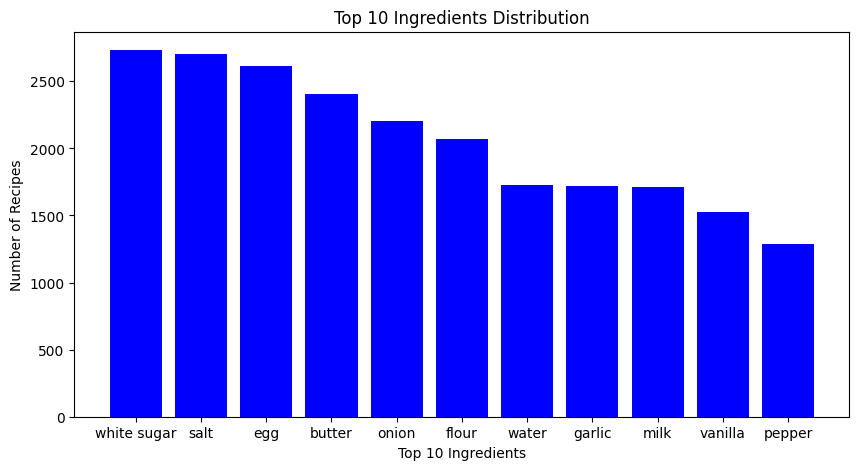

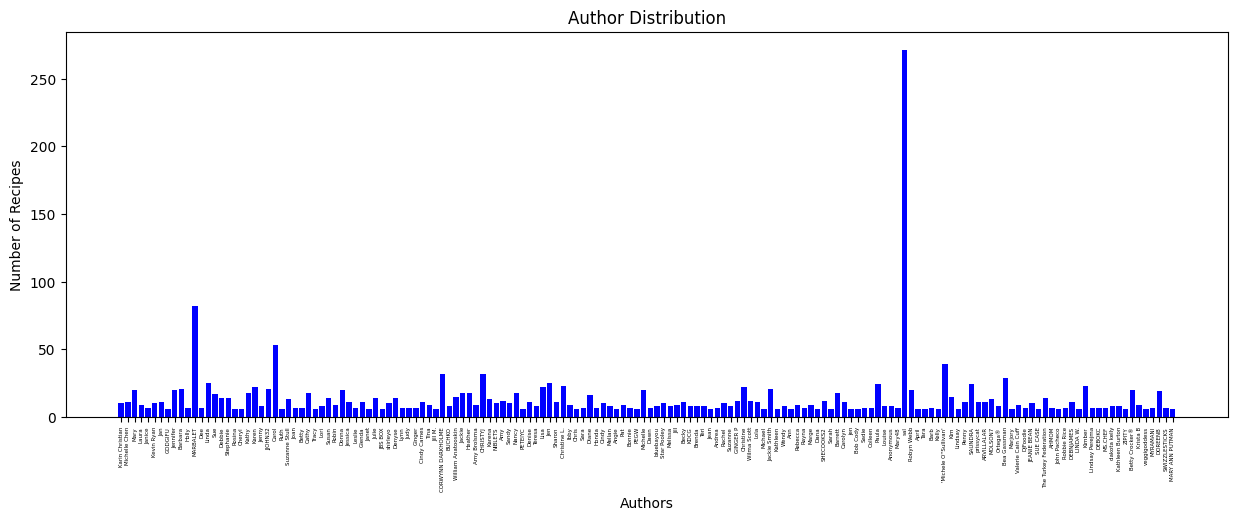

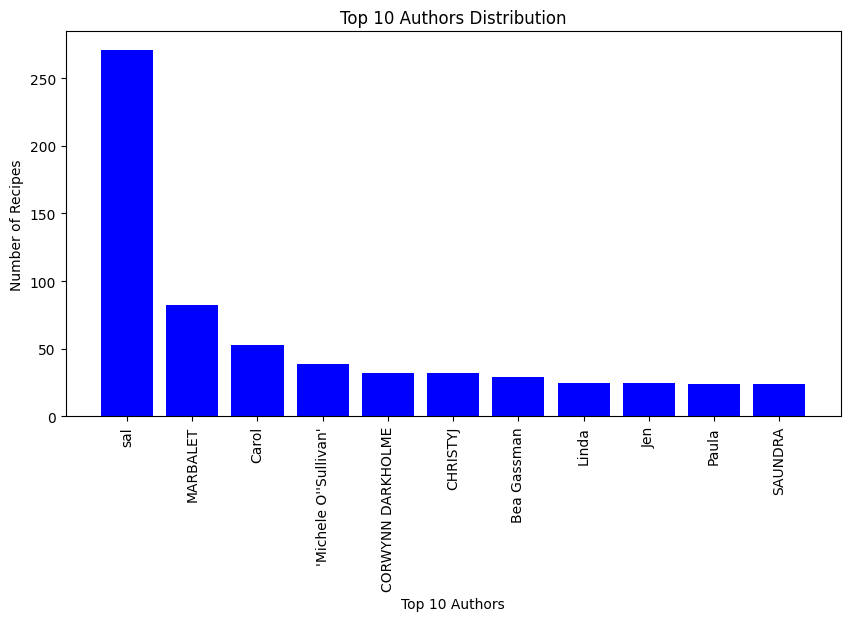

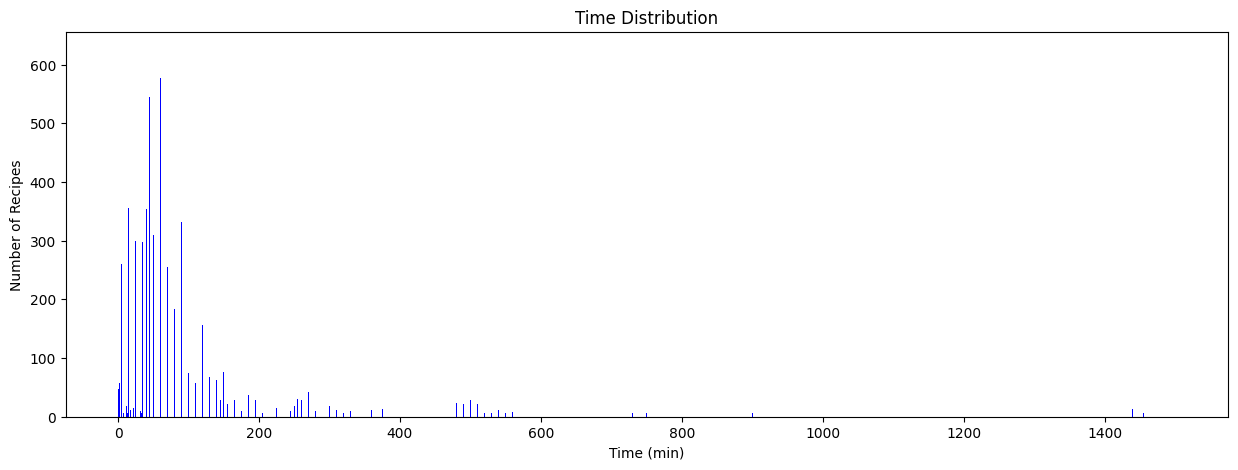

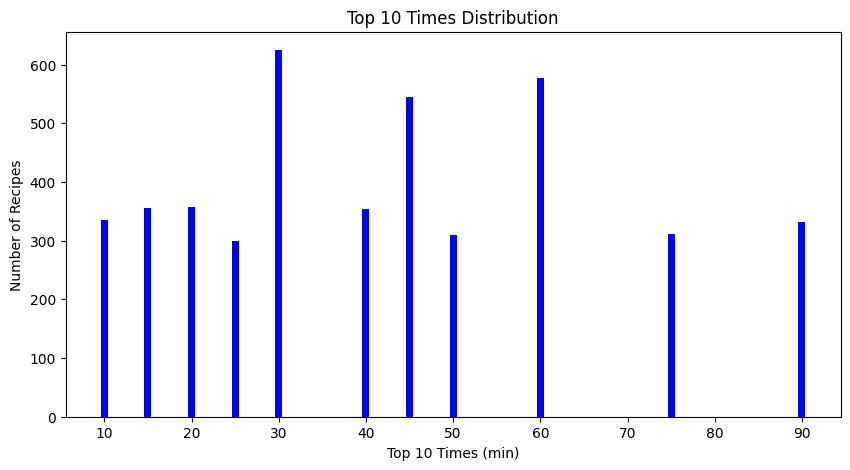

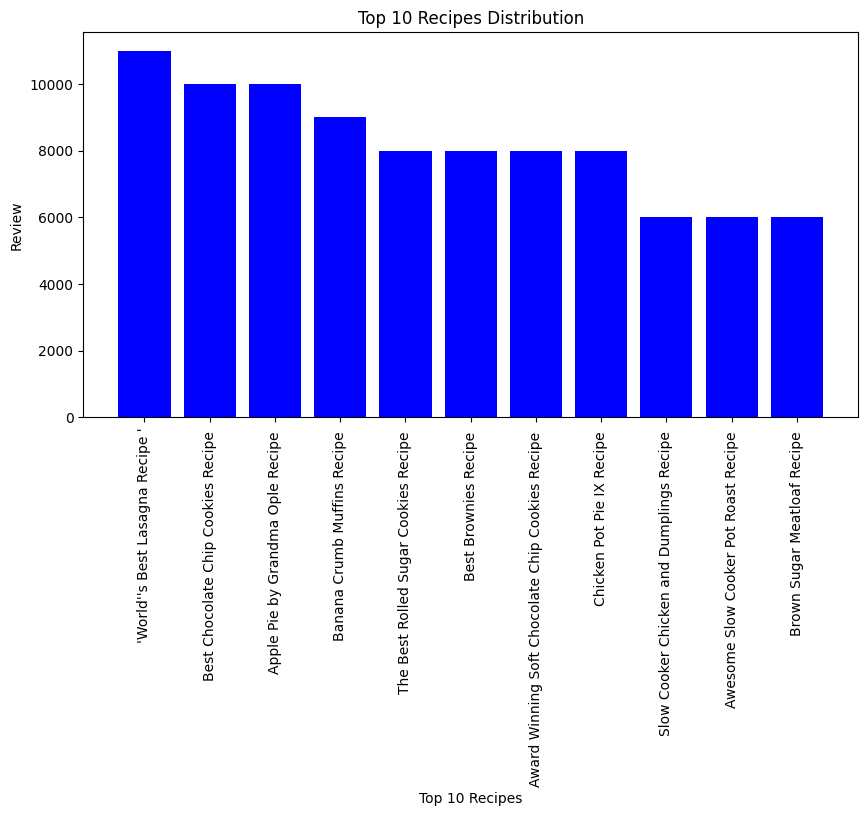

---------------------------------------- Welcome to Pendia ----------------------------------------
1- Log In;
2- Sing In;
0- Leave;
Name: Carlos
Password: 1234
---------------------------------------- Hi Carlos ----------------------------------------
Current date: 2023-12-6
Do you want to know what ingredients are expired and what are about to expire? (1- Yes/2- No)
1- Register Product
2- Eliminate Product
3- Make Recipe
4- Rank a Recipe
5- Leave

-------------------- Make Recipe --------------------
What recipes do you want? (1-By recipes ranking/2-By author ranking)
Time to spent doing the recipe: 1h 
--------------------
Here you have our recommended recipes!
--------------------
Recipes with ingredients almost expired:
French Toast I Recipe : ***
	-Ingredients about to expire: bread; 
	-Ingredients missing: cinnamon; 
Cream of Tomato Soup Recipe : 0
	-Ingredients about to expire: onion; 
	-Ingredients missing: tomato; 
--------------------
List of recipes recommended(by rating):


In [421]:
if __name__ == '__main__':
    main()